In [1]:
from utils.dataloader import *
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
img_dir, img_path, prob, types = load_data()

print(img_dir)

print(len(img_path), 
      len(prob),
      len(types))

/Users/moooooo16/Documents/Computer Vision/Project/elpv/data
2624 2624 2624


In [3]:
data = pd.DataFrame({'img_path': img_path, 'prob': prob, 'types': types})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_path  2624 non-null   object 
 1   prob      2624 non-null   float64
 2   types     2624 non-null   object 
dtypes: float64(1), object(2)
memory usage: 61.6+ KB


In [4]:
data.agg(['count', 'nunique'])

img_path  prob  types
count        2624  2624   2624
nunique      2624     4      2

In [5]:
data['prob'].value_counts()

0.000000    1508
1.000000     715
0.333333     295
0.666667     106
Name: prob, dtype: int64

In [6]:
data['types'].value_counts()

poly    1550
mono    1074
Name: types, dtype: int64

In [7]:
data.groupby(['prob', 'types']).size()

prob      types
0.000000  mono     588
          poly     920
0.333333  mono     117
          poly     178
0.666667  mono      56
          poly      50
1.000000  mono     313
          poly     402
dtype: int64

(300, 300)


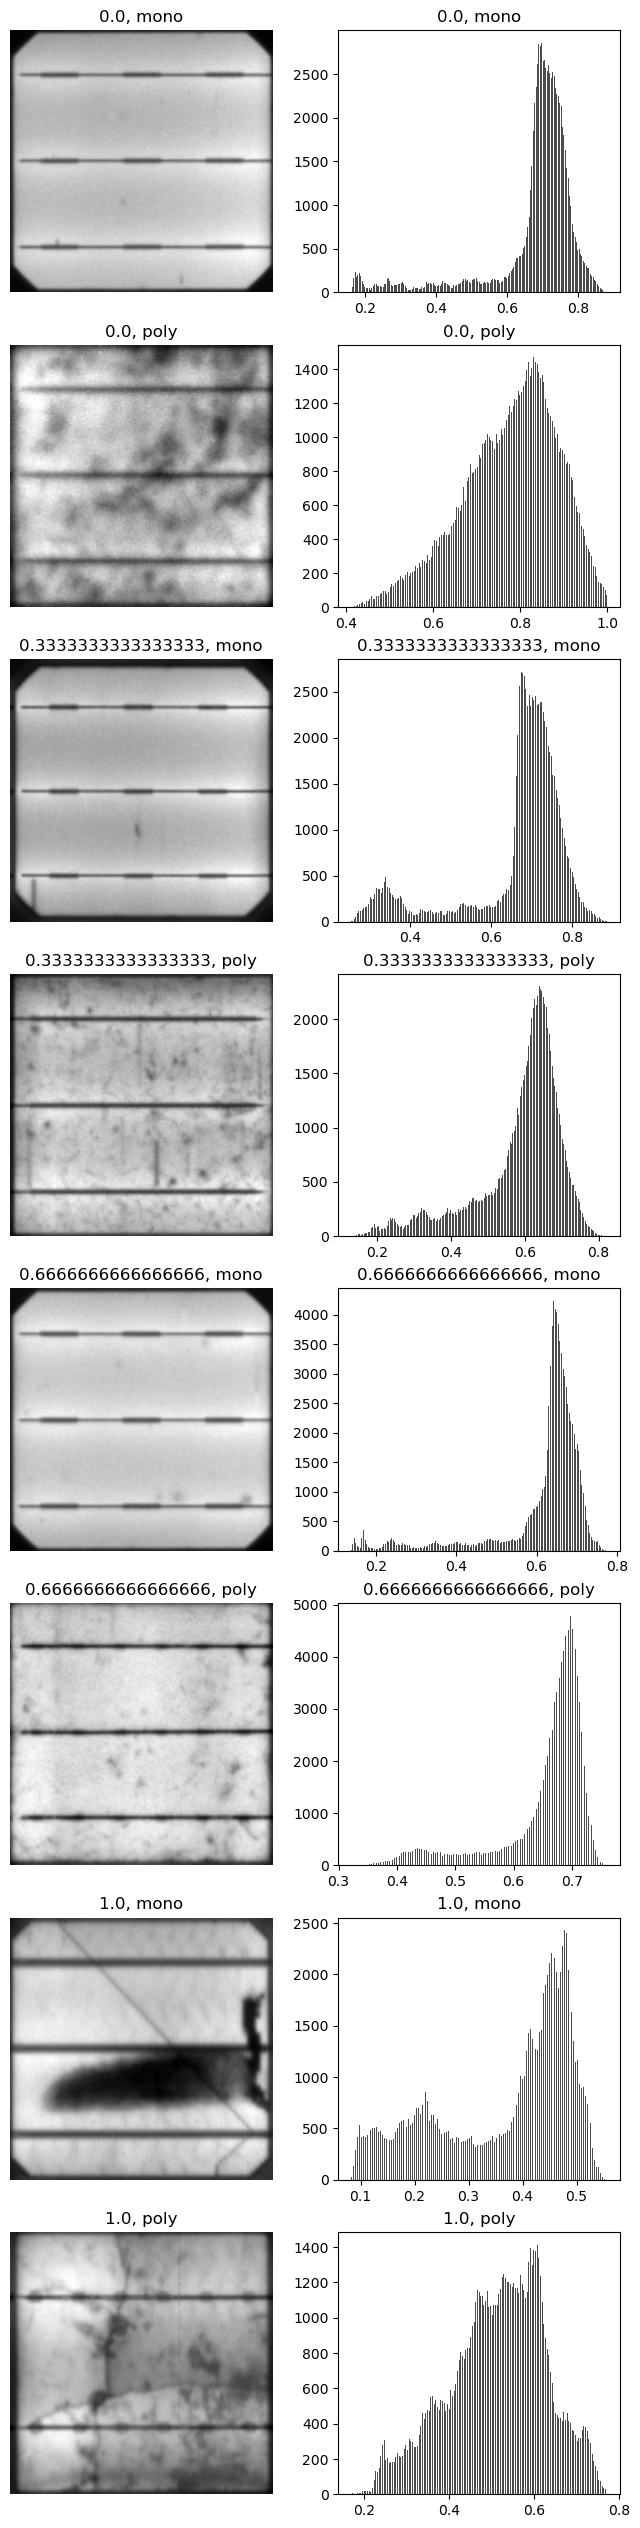

(300, 300)


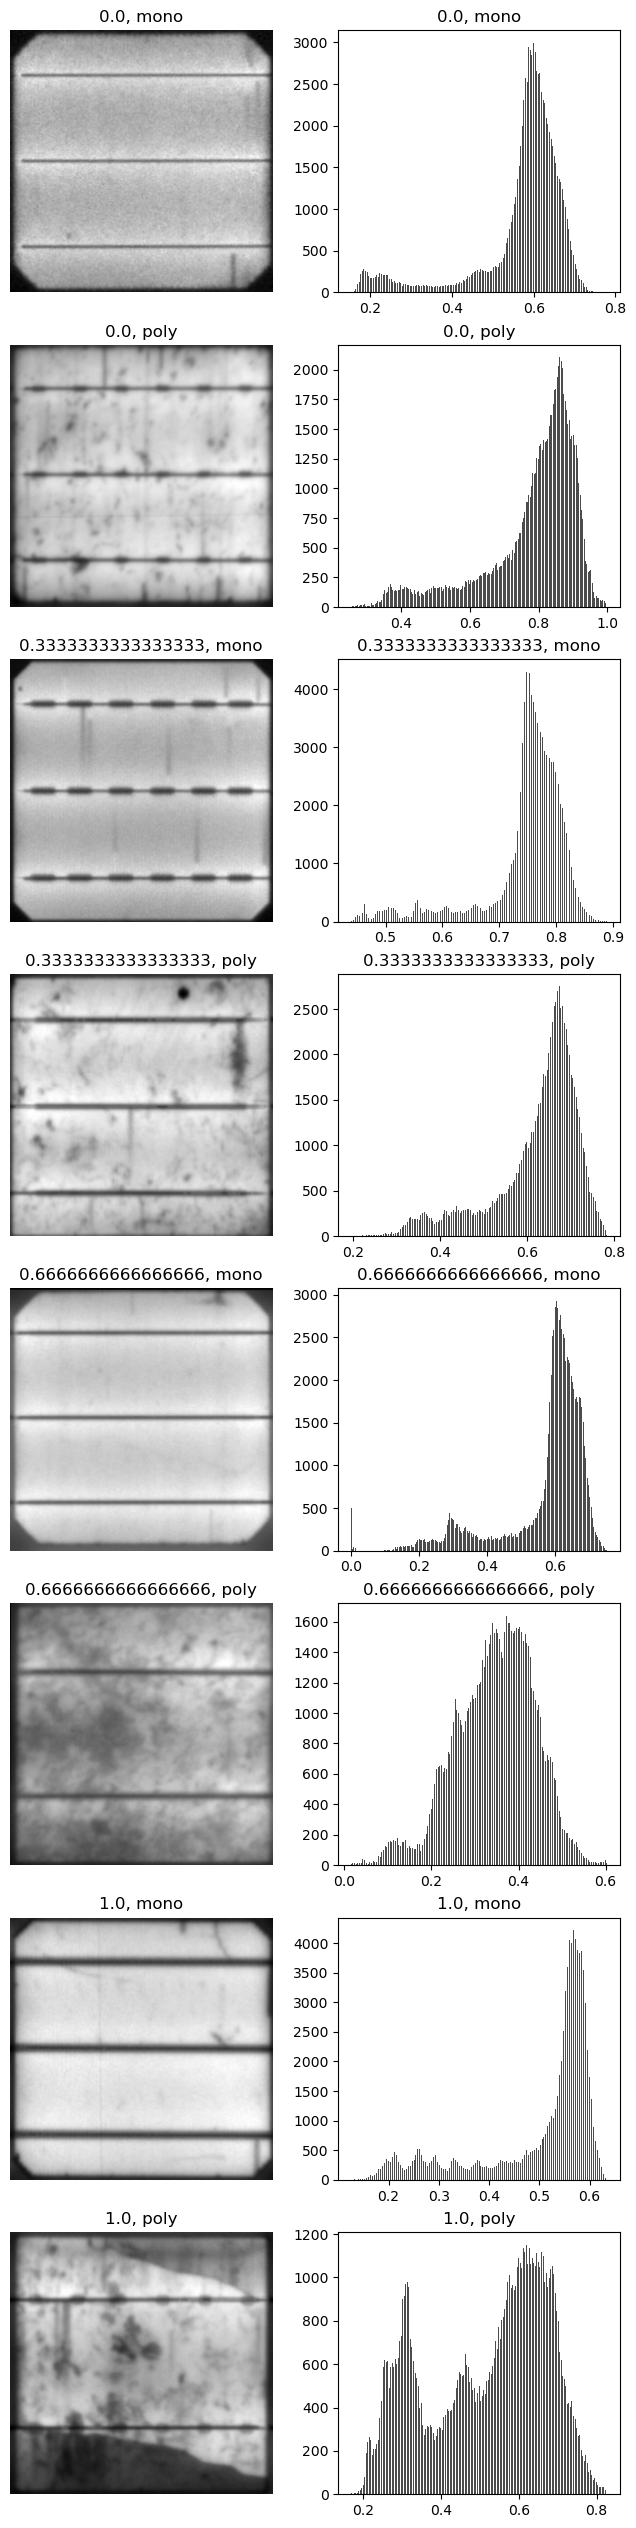

(300, 300)


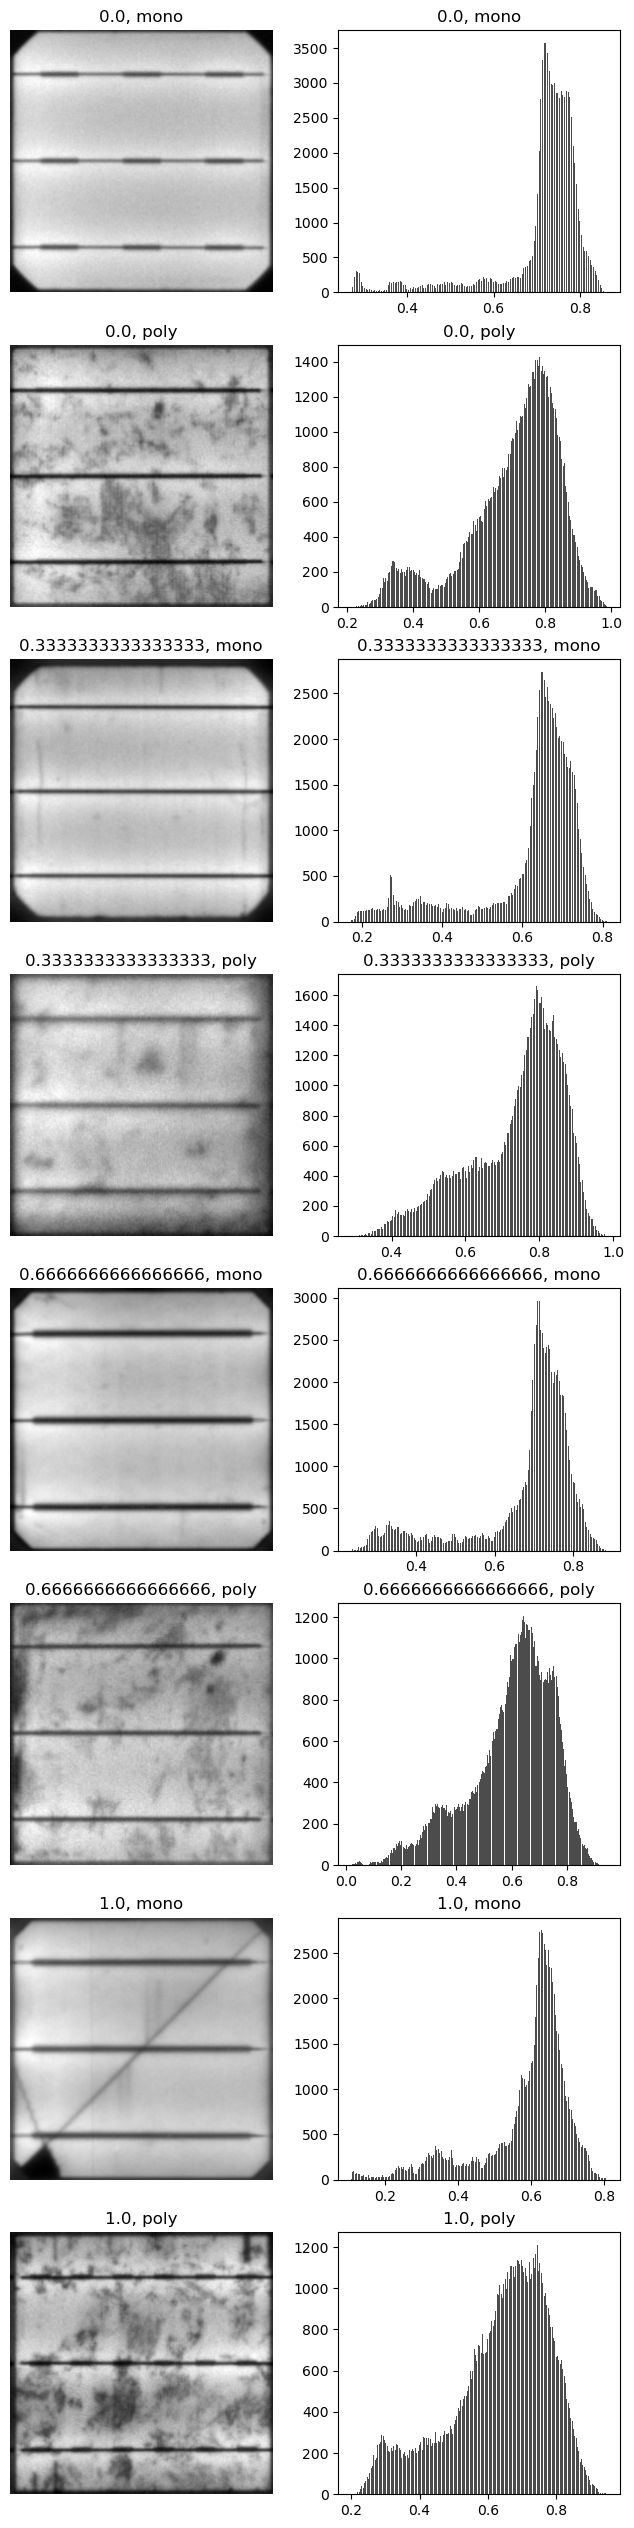

(300, 300)


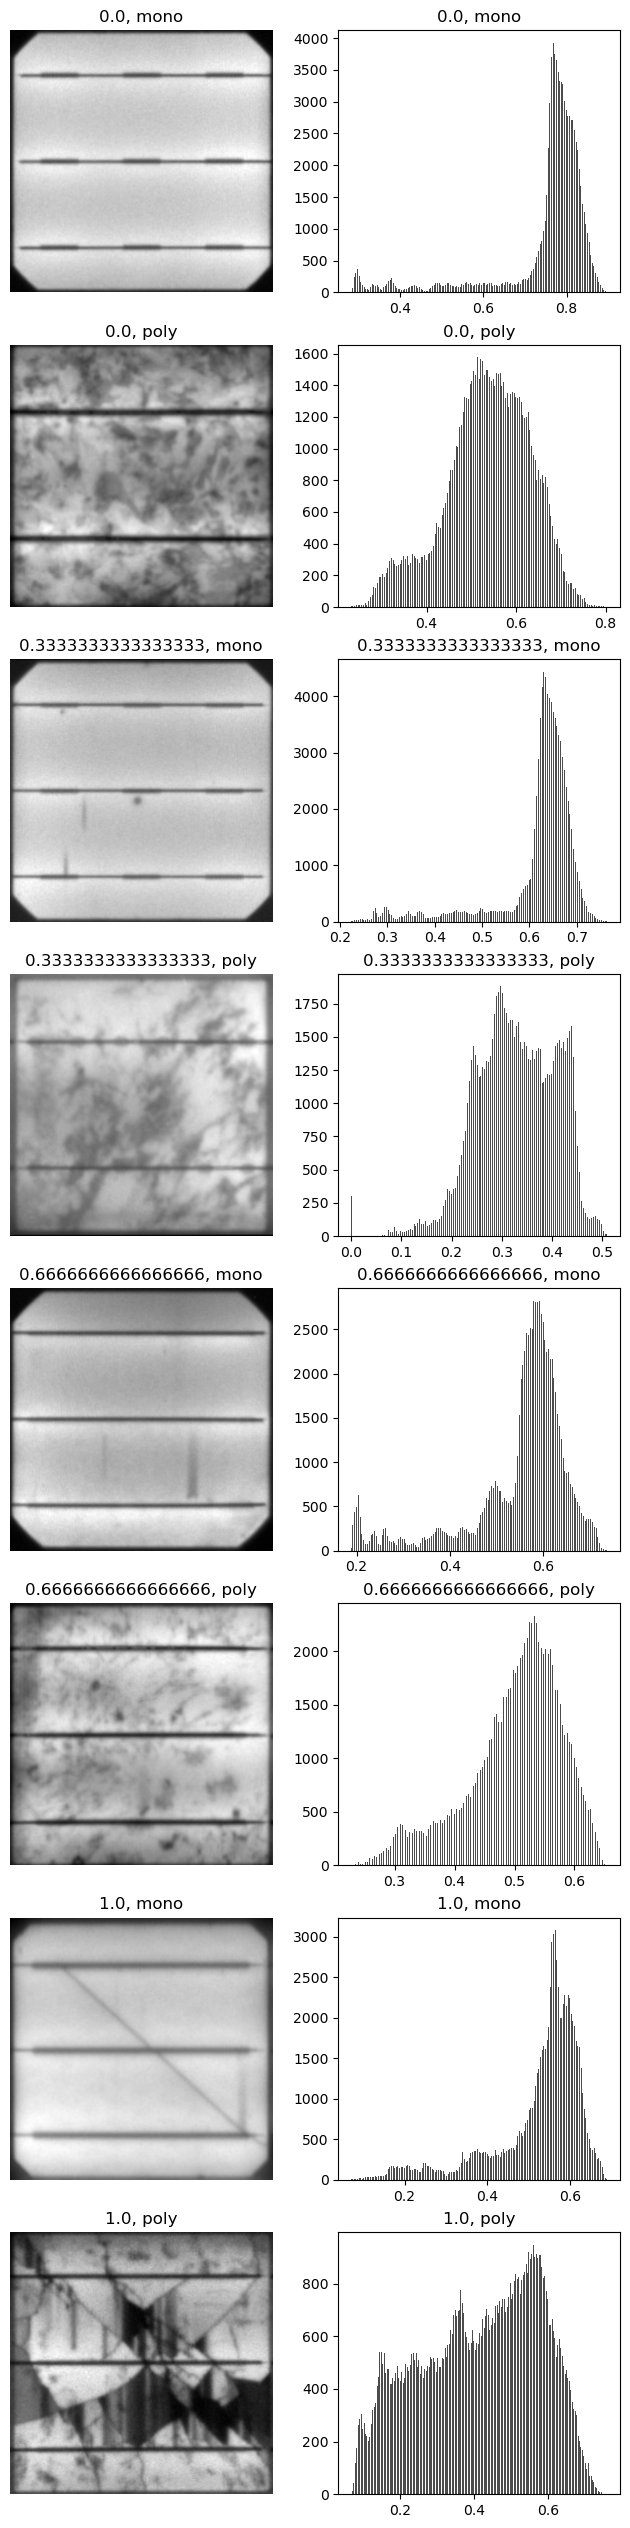

(300, 300)


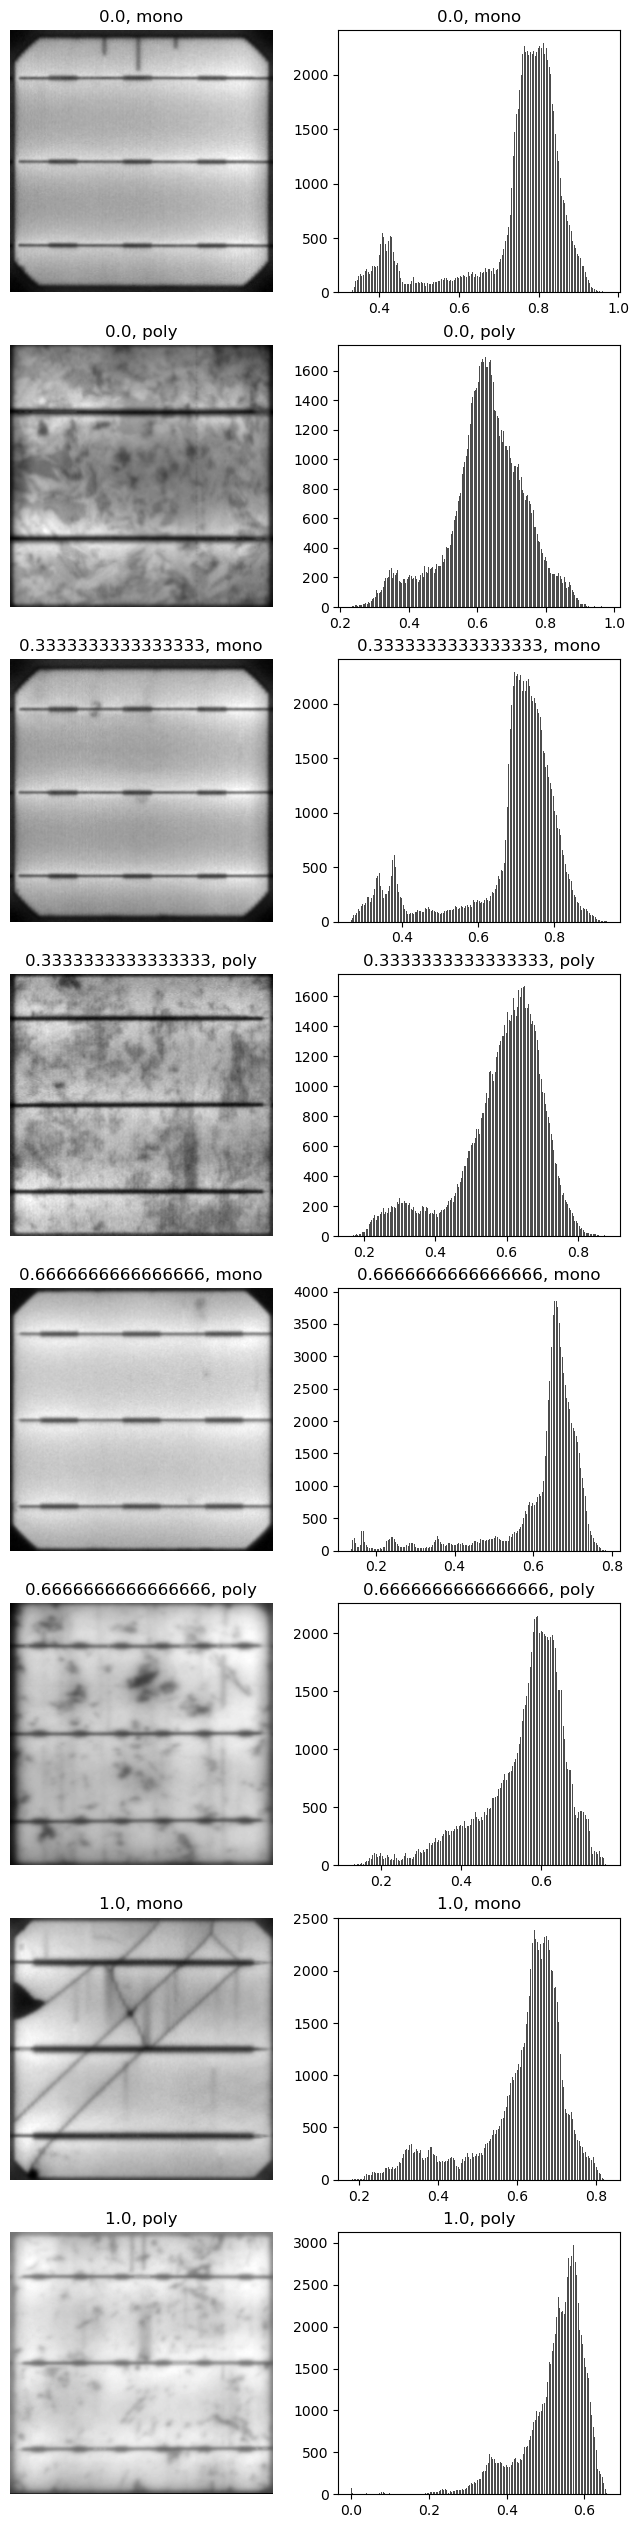

(300, 300)


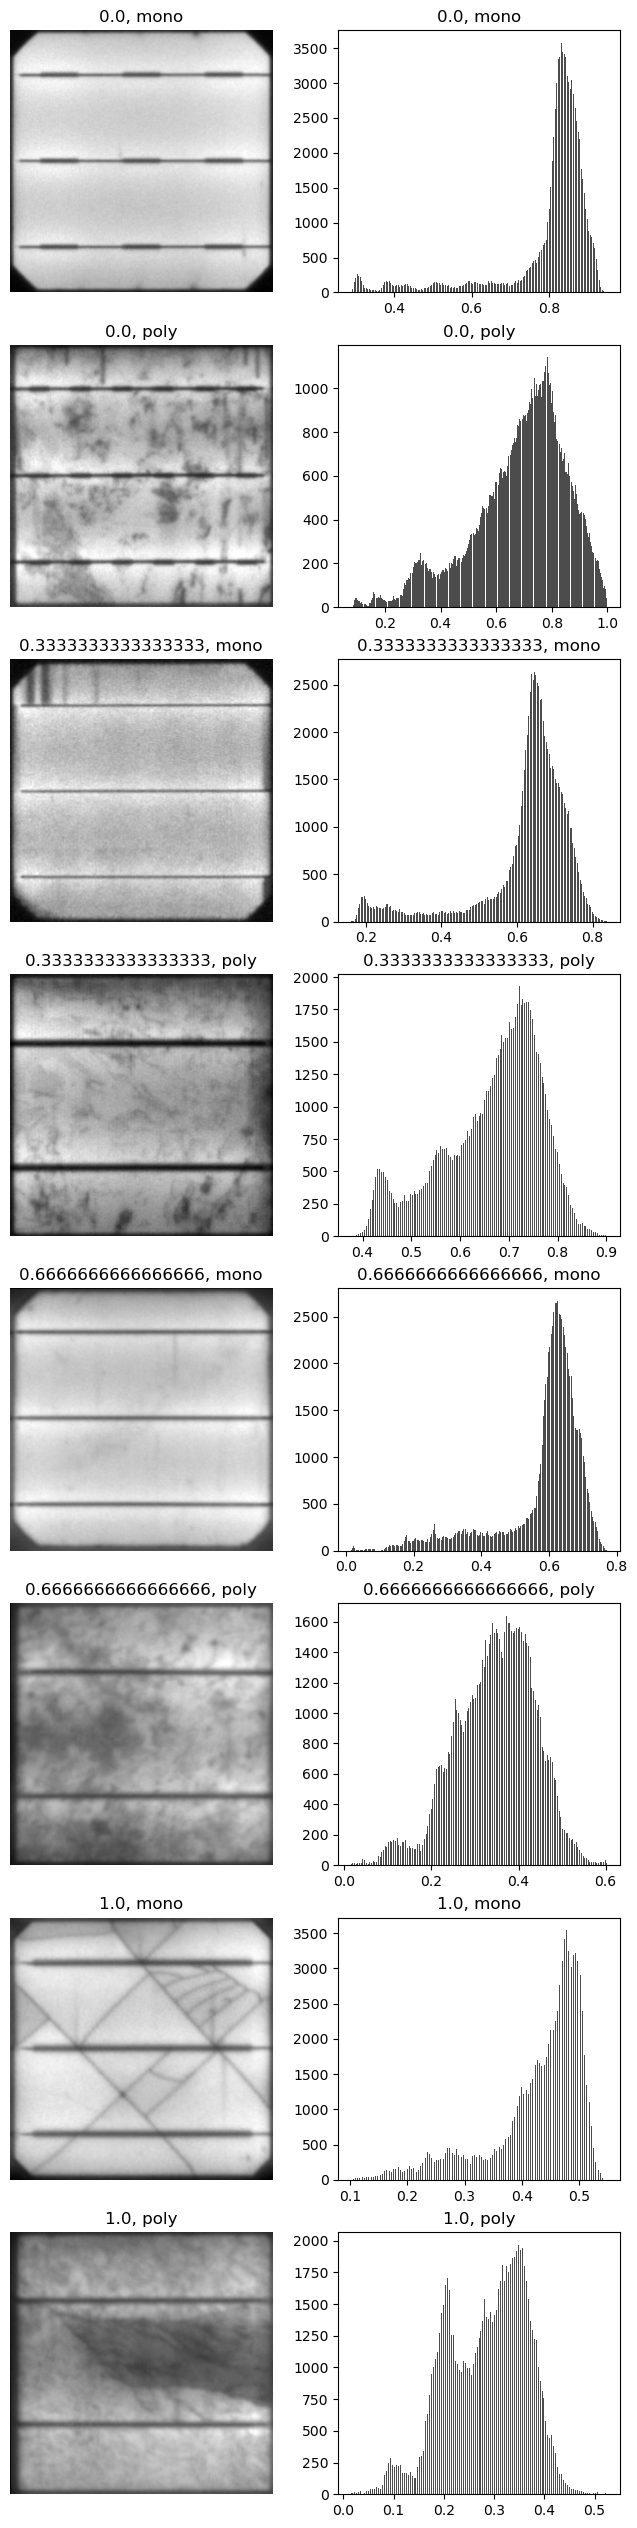

In [8]:
def at_galance(seed = 99, img_dir = img_dir, data = data):
    grouped = data.groupby(['prob', 'types'])
    sample = grouped.apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    
    _, axes = plt.subplots(8,2, figsize=(8, 32))
    
    for idx, row in sample.iterrows():


        img = plt.imread(os.path.join(img_dir, row['img_path']))
        
        if idx== 0:
            print(img.shape)
            
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'{row["prob"]}, {row["types"]}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].hist(img.flatten(), bins=256, color='black', alpha=0.7)
        axes[idx, 1].set_title(f'{row["prob"]}, {row["types"]}')
    
    plt.show()
            
    return sample

for i in range(6):
    at_galance(i)

<Axes: xlabel='prob'>

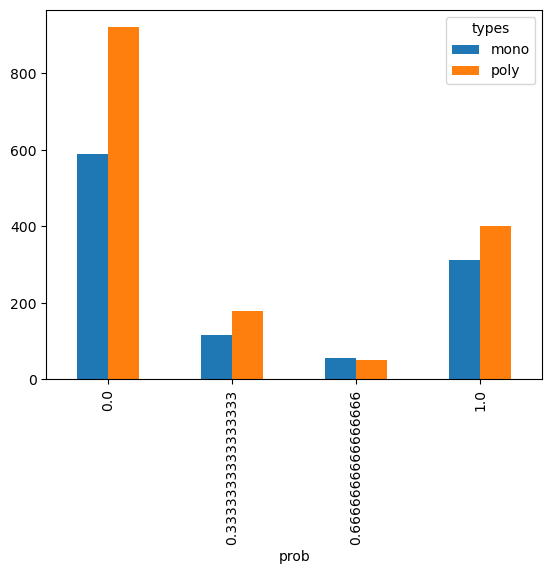

In [9]:
data.groupby(['prob', 'types']).size().unstack().plot(kind='bar')

# Findings

- Class label interpreter:
  - fully functional (0% probability of being defective), 
  - possibly defective (33% probability), 
  - likely defective (67% probability), or 
  - certainly defective (100% probability).

- Mono and poly are different in
  - shape of img background
  - defect pattern
  - mono-crystalline silicon wafers and multi-crystalline silicon wafers
  - mono and poly are balanced
- Defecet are not clear to naked eye
- Images are 8 bits gray-scale, 300 x 300 pixels
- class are imbalanced, with majority are "fully functional"


From paper:
- Expert identified 12 features intrinsic to most PV modules
- 12 defecet extrinsic to solar cells
- 


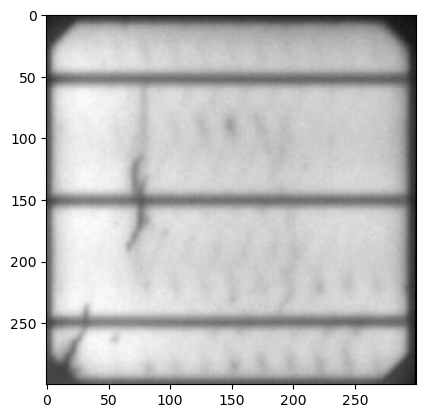

In [13]:
img = plt.imread(os.path.join(img_dir,data['img_path'][0]))
plt.imshow(img, cmap='gray')

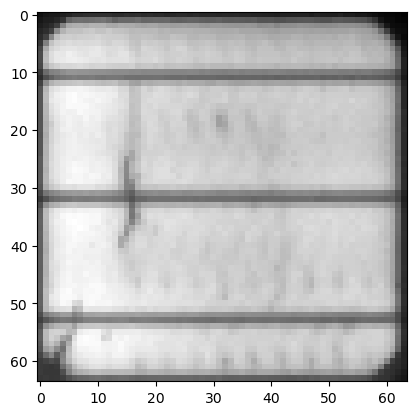

In [14]:
resized = cv.resize(img, (64, 64))
plt.imshow(resized, cmap='gray')

In [19]:
def my_triangle(img):

    count, bins = np.histogram(img.ravel(), bins=255, range=(0, 255))
    # p1: max count, with its index
    p1 = np.array([np.argmax(count), np.max(count)])
    temp = np.max(np.nonzero(count))
    
    # p2: last non-zero count, with its index
    p2 = np.array([temp, count[temp]])
    line = p2-p1
    max_d = -1
    best_p3 = None
    # bins: 0:255, count: count of each pixel
    for p3 in zip(bins[p1[0]:p2[0]+1], count[p1[0]:p2[0]+1]):
        p3 = np.array(p3)
        d = np.linalg.norm(np.cross(line,p1-p3)/np.linalg.norm(line))
        if d > max_d:
            max_d = d
            best_p3 = p3
    threshold = best_p3[0]

    return (img > threshold).astype(np.uint8) * 255, threshold

In [22]:
def my_isodata(img):
    t = threshold = np.random.randint(0, 256)
    allowance = 0.0000001

    while True: 
        left = img[img <= threshold]
        right = img[img > threshold]
        
        mu0 = mu1 = 0
        
        if len(left) != 0:
            
            mu0 = np.mean(left)
            
        if len(right) != 0:
            mu1 = np.mean(right)
            
        threshold = (mu0 + mu1) / 2
        if abs(t - threshold) < allowance:
            break
        t = threshold
        
    return (img > threshold).astype(np.uint8) * 255, threshold.astype(np.uint8) 

In [24]:
def my_otsu(img):
    best_threshold = 0
    best_sigma = 0
    for threshold in range(256):
        
        mu0 = mu1 = 0
        p0 = np.sum(img <= threshold) / img.size
        p1 = np.sum(img > threshold) / img.size
        if p0 != 0:
            mu0 = np.mean(img[img <= threshold])
        if p1 != 0:
            mu1 = np.mean(img[img > threshold])
        sigma = p0 * p1 * (mu0 - mu1) ** 2
        
        if sigma > best_sigma:
            best_sigma = sigma
            best_threshold = threshold
    return (img > best_threshold).astype(np.uint8) * 255, best_threshold

In [30]:
def thresholding(img, prob, types):

    otsu, otsu_threh = my_otsu(img)
    isodata, isodata_thresh = my_isodata(img)
    # triangle = cv2.threshold(img, 0, 255, cv2.THRESH_TRIANGLE)[1]
    triangle, triangle_thresh = my_triangle(img)
    
    _, ax = plt.subplots(1, 5, figsize=(25,5))
    
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'{prob}, {types}')
    
    ax[1].hist(img.ravel(), bins=256, range=(0, 255), color = 'black')
    
    ax[1].axvline(otsu_threh, color='r')
    ax[1].axvline(isodata_thresh, color='g')
    ax[1].axvline(triangle_thresh, color='b')
    ax[1].legend(['Otsu', 'Isodata', 'Triangle'])
    ax[1].set_title('Histogram')
    
    ax[2].imshow(otsu, cmap='gray')
    ax[2].set_title('My Otsu')
    
    ax[3].imshow(isodata, cmap='gray')
    ax[3].set_title('Isodata')

    ax[4].imshow(triangle, cmap='gray')
    ax[4].set_title('Triangle')
    
    # print(f'Otsu threshold: {otsu_threh}')
    # print(f'Isodata threshold: {isodata_thresh}')
    # print(f'Triangle threshold: {triangle_thresh}')


In [31]:
def transformation(img):
    grouped = data.groupby(['prob', 'types'])
    sample = grouped.apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    for idx, row in sample.iterrows():
        img = plt.imread(os.path.join(img_dir, row['img_path']))
        thresholding(img*255, row['prob'], row['types'])

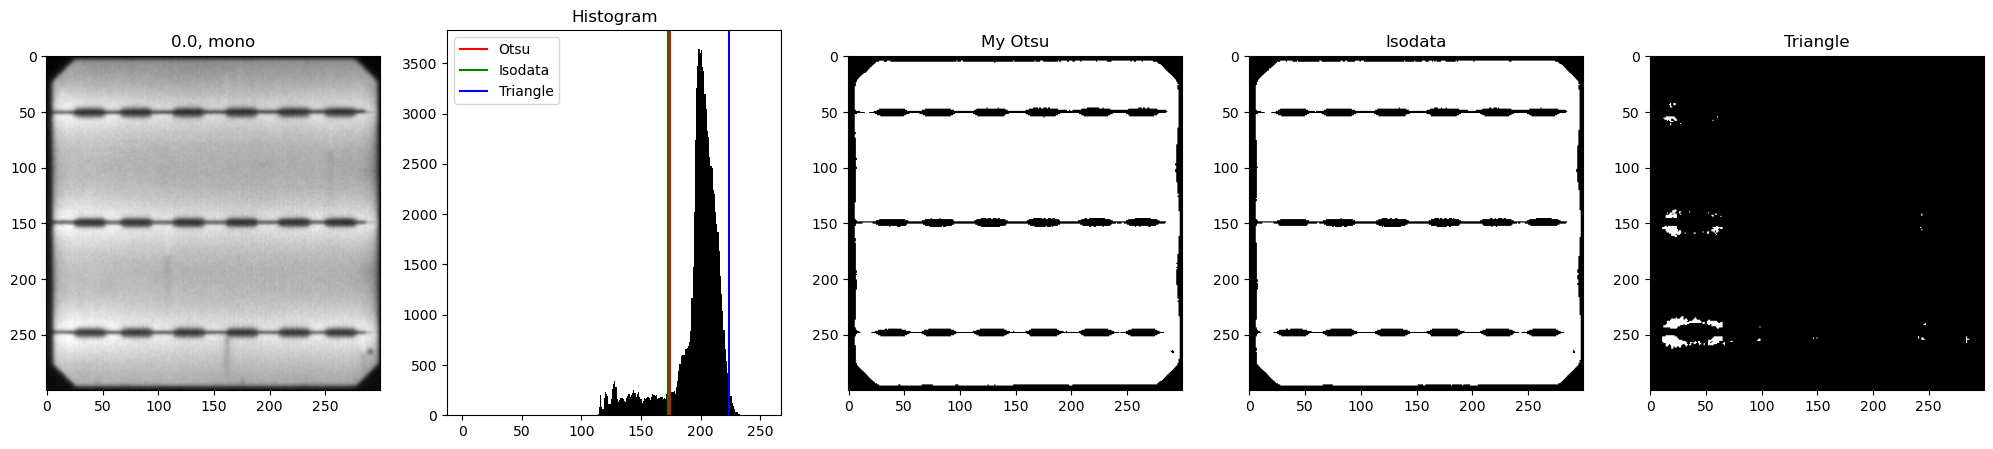

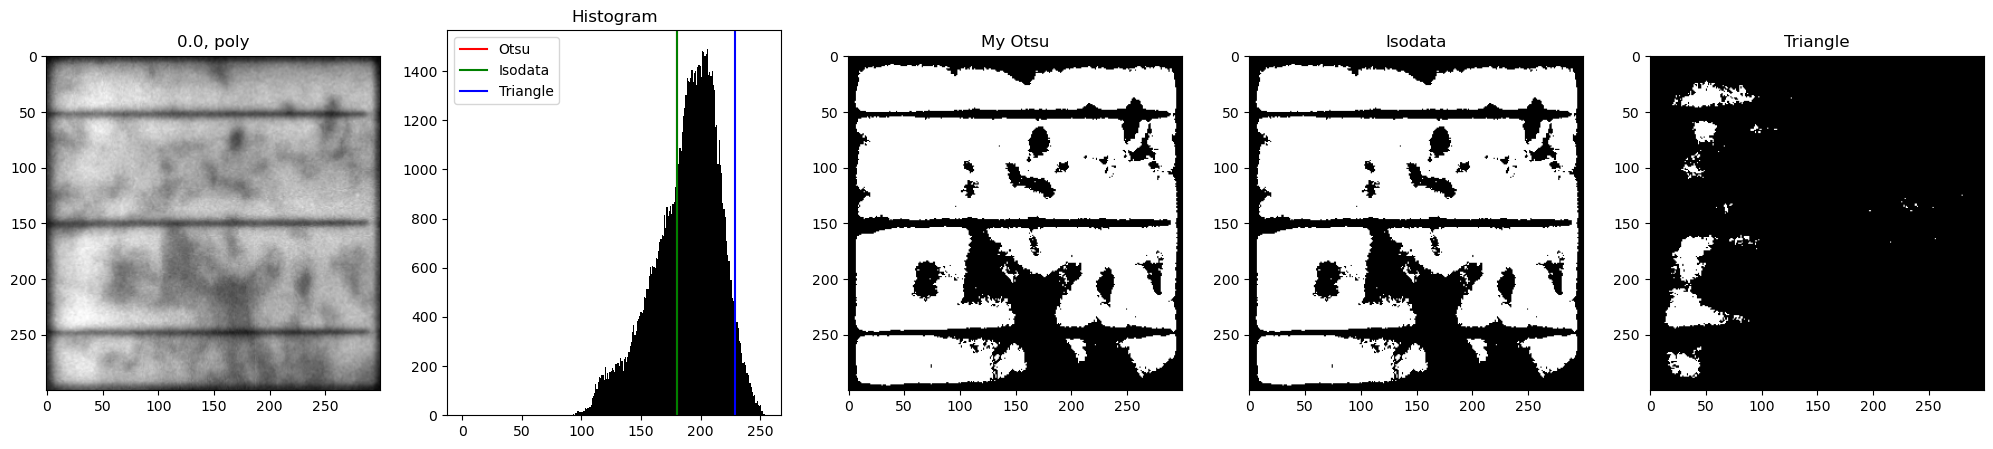

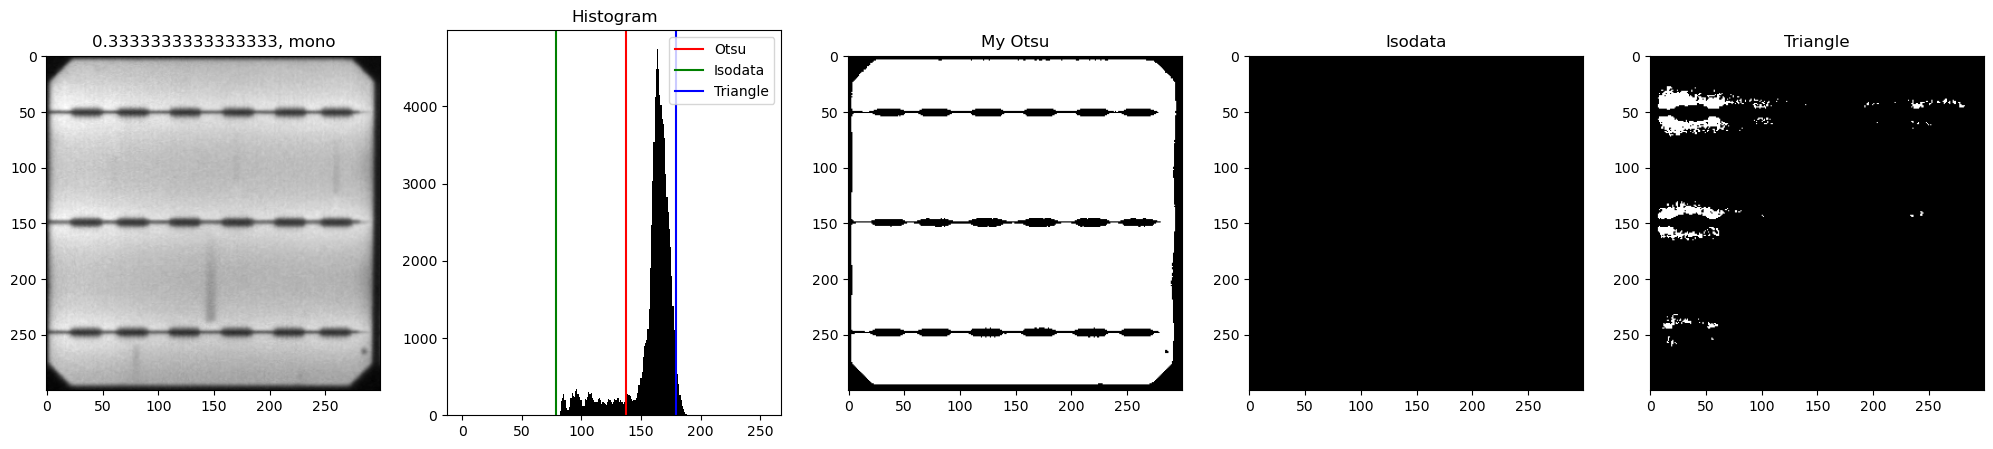

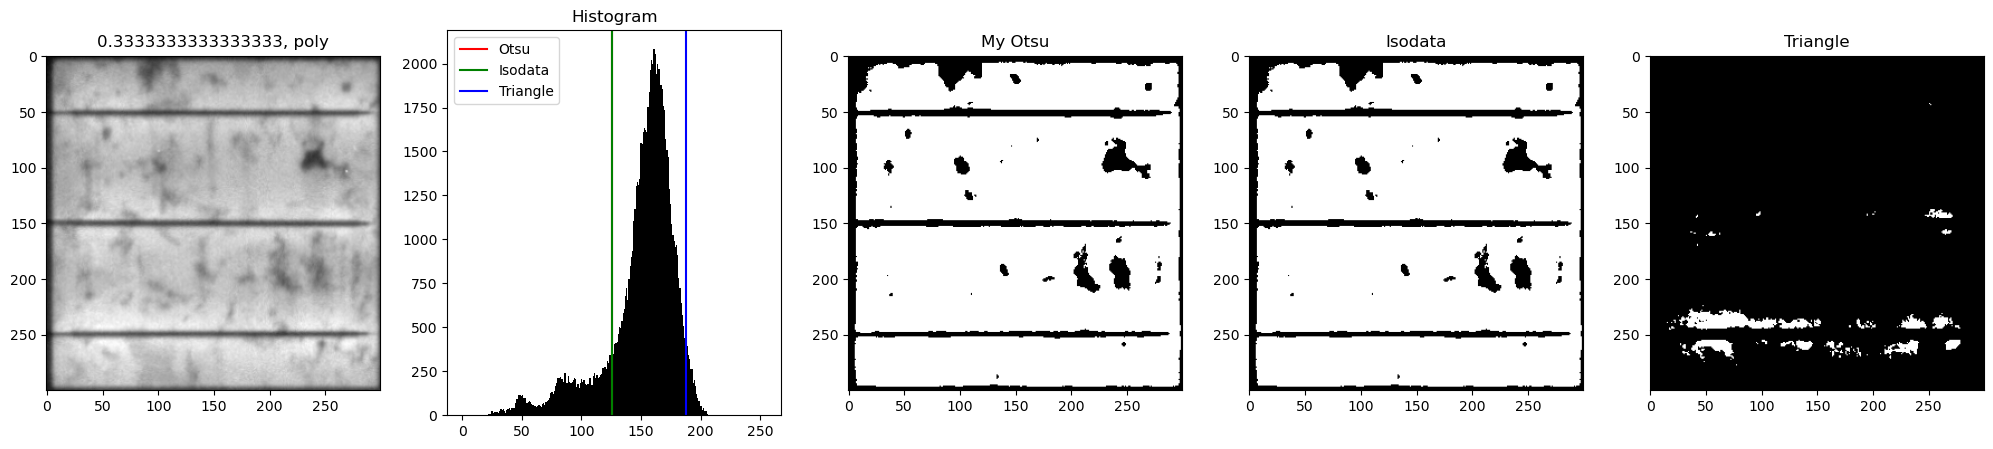

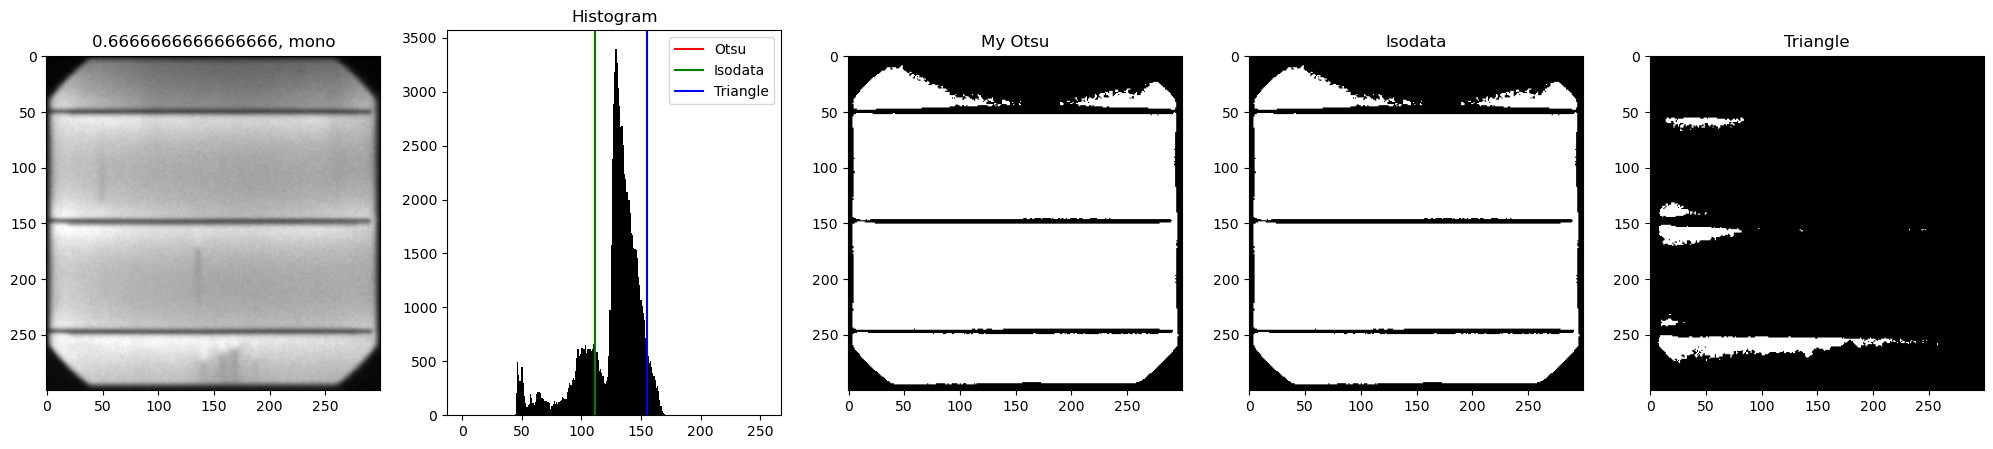

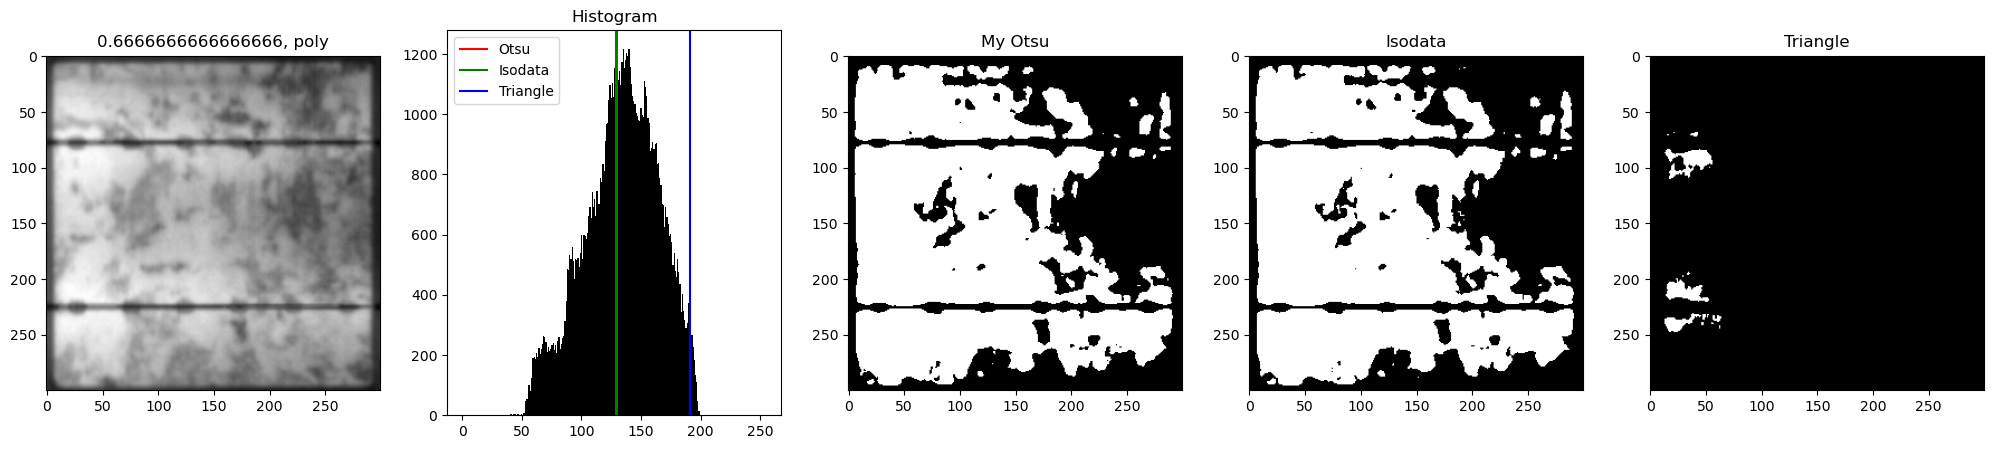

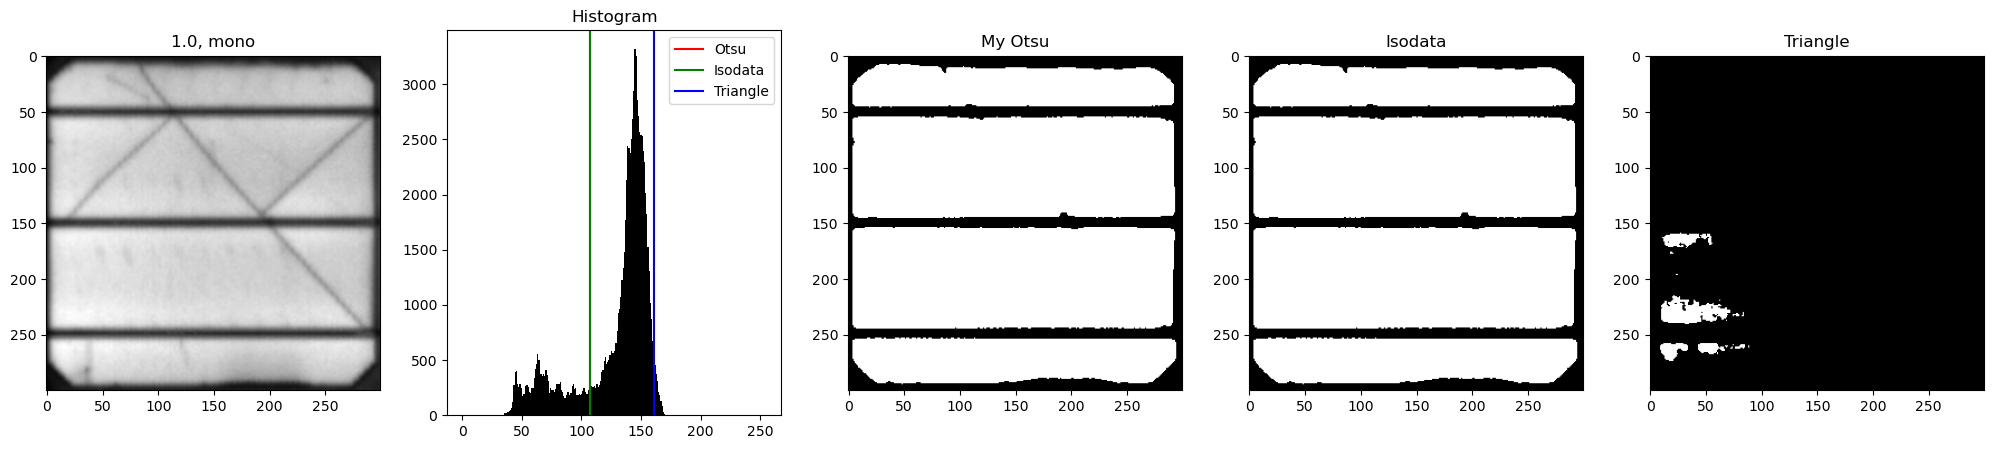

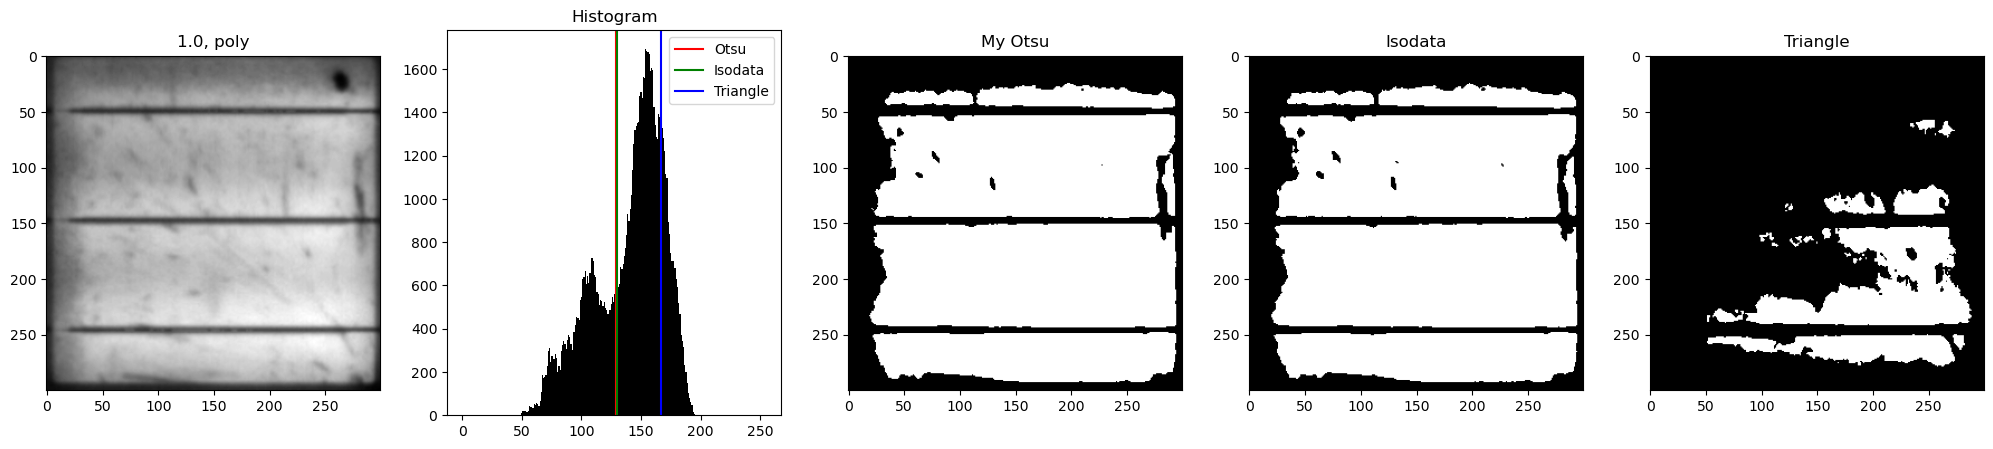

In [32]:
transformation(None)

In [45]:
kernel = np.array([[1, 1, 1,], [1, -8, 1], [1, 1, 1]])

def zero_crossing(img, threshold=0):
    
    
    
    result = np.zeros_like(img).astype(np.uint8)
    
    
    
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            
            if result[i, j] != 0:
                continue
            
            if img[i-1, j-1] * img[i+1, j+1] < threshold:
                result[i, j] = 255
                continue
            
            if img[i-1, j] * img[i+1, j] < threshold:
                result[i, j] = 255
                continue
            
            if img[i-1, j+1 ] * img[+1, j-1] < threshold:
                result[i, j] = 255
                continue
            
            if img[i, j-1] * img[i, j+1] < threshold:
                result[i, j] = 255
                continue
            
            
    return result
    
def streching_function(x,c,d):
    return np.clip((x - c) * (255 / (d - c)), 0, 255)

def laplacian_image(img=None, kernel=kernel):
    
    img = img.astype(np.float32)
    kernel = kernel.astype(np.float32)
    
    step = kernel.shape[0] // 2
    
    laplacian = np.zeros_like(img)
    
    # i is x, j is y
    for i in range(step, img.shape[0] - step):
        for j in range(step, img.shape[1] - step):
            # print(img[i-step:i+step+1, j-step:j+step+1])
            laplacian[i, j] = np.sum(img[i-step:i+step+1, j-step:j+step+1] * kernel)
    
    return laplacian

laplacian = laplacian_image(img = img*255)
    

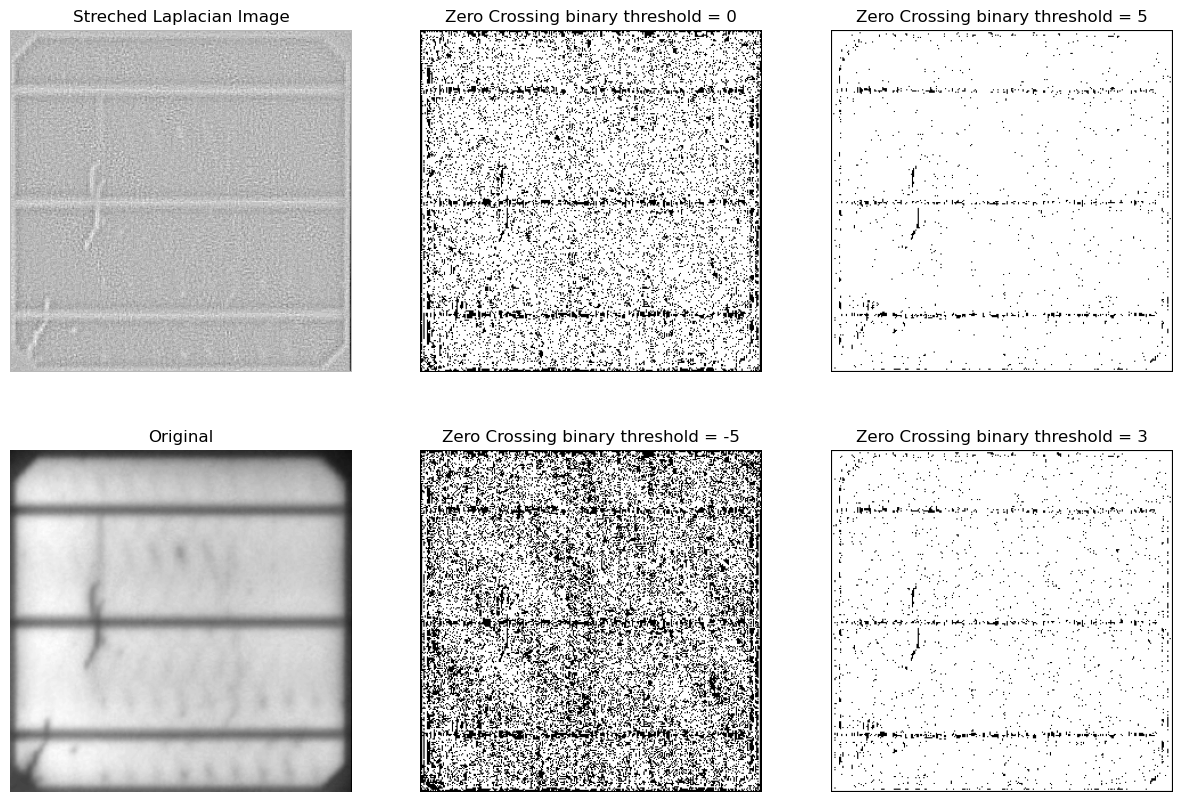

In [49]:

def plot_laplacian(img, laplacian):
    
    threhsold1 = 0
    threshold2 = 5
    threshold3 = -5
    threshold4 = 3
    threshold5 = -3
    
    zero_crossing_1 = zero_crossing(laplacian.copy(), threshold=threhsold1).astype(np.uint8)
    zero_crossing_2 = zero_crossing(laplacian.copy(), threshold=threshold2).astype(np.uint8)
    zero_crossing_3 = zero_crossing(laplacian.copy(), threshold=threshold3).astype(np.uint8)
    zero_crossing_4 = zero_crossing(laplacian.copy(), threshold=threshold4).astype(np.uint8)
    zero_crossing_5 = zero_crossing(laplacian.copy(), threshold=threshold5).astype(np.uint8)
                
    streched = streching_function(laplacian.copy(), np.min(laplacian), np.max(laplacian)).astype(np.uint8)
    
    # bright = laplacian.copy()
    # bright[bright < 0] = 0
    # bright[bright > 255] = 255
    
    # dark = laplacian.copy()
    # dark[dark > 0] = 0
    # dark[dark < -255] = -255
    
    _, axes = plt.subplots(2, 3, figsize=(15,10))
    
    
    axes[0,0].imshow(streched, cmap='gray', vmin=0, vmax=255)
    axes[0,0].set_title('Streched Laplacian Image')
    axes[0,0].axis('off')
    
    
    axes[0,1].imshow(zero_crossing_1, cmap='gray')
    axes[0,1].set_title(f'Zero Crossing binary threshold = {threhsold1}')
    axes[0,1].axis('off')
    
    axes[0,2].imshow(zero_crossing_2, cmap='gray')
    axes[0,2].set_title(f'Zero Crossing binary threshold = {threshold2}')
    axes[0,2].axis('off')
    
    
    axes[1,0].imshow(img, cmap='gray')
    axes[1,0].set_title('Original')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(zero_crossing_3, cmap='gray')
    axes[1,1].set_title(f'Zero Crossing binary threshold = {threshold3}')
    axes[1,1].axis('off')
    
    axes[1,2].imshow(zero_crossing_4, cmap='gray')
    axes[1,2].set_title(f'Zero Crossing binary threshold = {threshold4}')
    axes[1,2].axis('off')
    # axes[3].imshow(bright, cmap='gray')
    # axes[3].set_title('Bright part')
    # axes[3].axis('off')

    
    plt.show()
    
plot_laplacian(img*255, laplacian)